In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from bidding_environment import FirstPriceAuction
from bidding import HedgeAgent, FFMultiplicativePacingAgent
from Competing_bids_generator import generate_bids

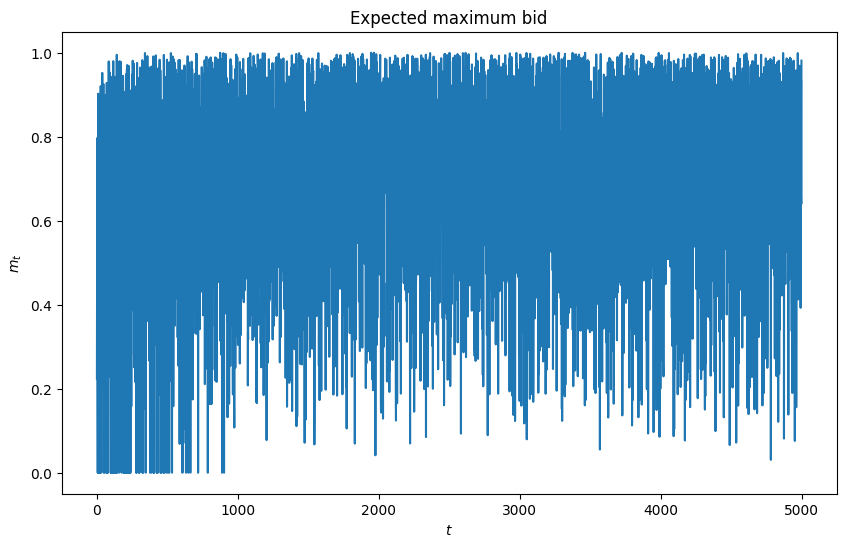

In [90]:
### Adversarial Bidders

n_advertisers = 3
n_users = 5000
Budget = 300
my_valuation = 0.6
rho = Budget/n_users
# non-trivial scenario: competitors sample bids from a uniform with range varying over time

other_bids = np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t) for t in range(n_users)]).T

#other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))

# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

In [91]:
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


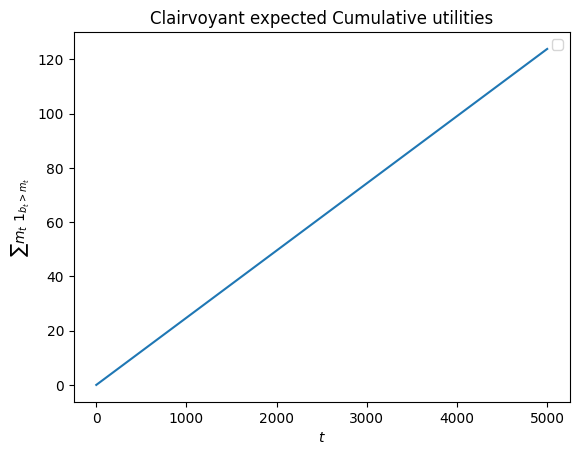

In [101]:
plt.title('Clairvoyant expected Cumulative utilities')
plt.plot(np.cumsum(expected_clairvoyant_utilities))
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

In [93]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=Budget,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 602


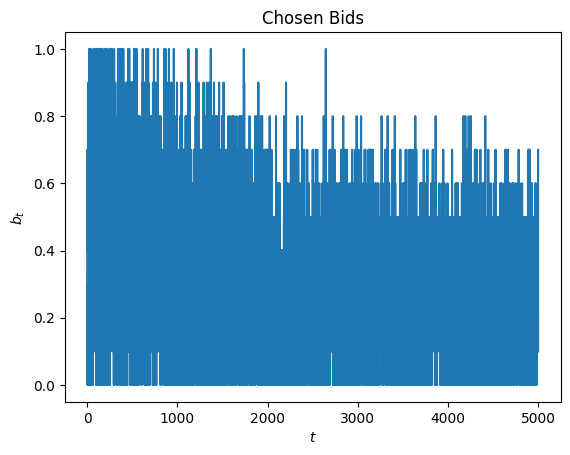

In [94]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


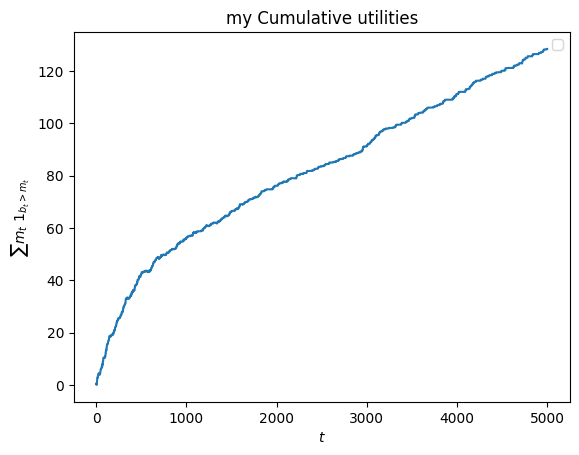

In [100]:
plt.title('my Cumulative utilities')
plt.plot(np.cumsum(utilities))
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

Perchè ottengo regret negativa? forse il clairvoyant è un po' stupido?

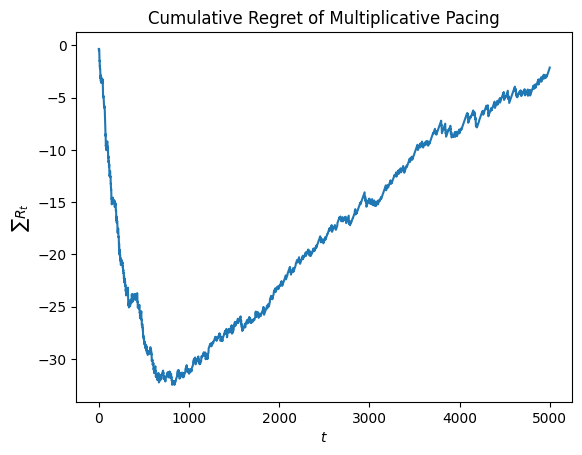

In [96]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

In [97]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=Budget,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

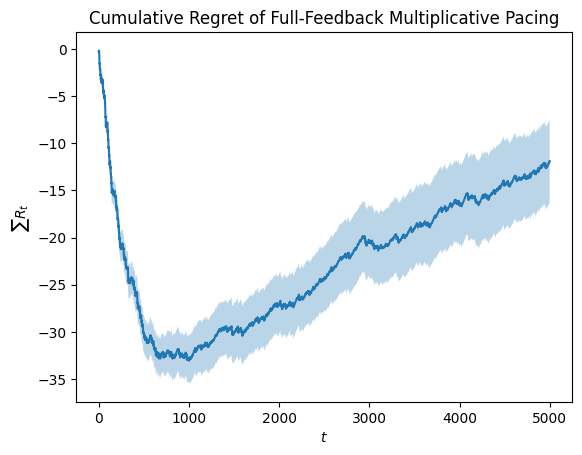

In [98]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()